## **Importing Libraries**

In [1]:
import numpy as np

import keras

from keras import backend as K

from keras.layers.core import Dense, Dropout

from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix

import itertools

import matplotlib.pyplot as plt

import tensorflow as tf

import glob



In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Loading dataset from Google drive**

In [3]:
train_path = '/content/gdrive/My Drive/trainM/' 

valid_path ='/content/gdrive/My Drive/validateM/'

test_path='/content/gdrive/My Drive/testM/'

In [4]:
num_train_samples = 2100

num_val_samples = 300

num_test_samples=600

train_batch_size = 32

val_batch_size = 32

test_batch_size=600

image_size = 224

In [5]:
train_steps = np.ceil(num_train_samples / train_batch_size)

val_steps = np.ceil(num_val_samples / val_batch_size)

test_steps=np.ceil(num_test_samples / test_batch_size)

l=["early_blight","healthy","late_blight"]

In [6]:
train_batches = ImageDataGenerator(

    preprocessing_function= keras.applications.mobilenet.preprocess_input).flow_from_directory(

    directory=train_path,

    target_size=(image_size, image_size),

    batch_size=train_batch_size,
    
     )

Found 2100 images belonging to 3 classes.


## **Sample Image used for Classification**

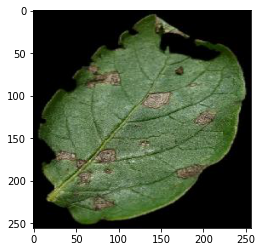

In [7]:
g = glob.glob('/content/gdrive/My Drive/trainM/early_blight/*.jpg')
import matplotlib.image as mpimg
for i in g:
  image = mpimg.imread(i)
  plt.imshow(image)
  plt.show()
  break

In [8]:
valid_batches = ImageDataGenerator(

    preprocessing_function= keras.applications.mobilenet.preprocess_input).flow_from_directory(

    directory=valid_path,

    target_size=(image_size, image_size),

    batch_size=val_batch_size,
    )


Found 300 images belonging to 3 classes.


In [9]:
test_batches = ImageDataGenerator(

    preprocessing_function= keras.applications.mobilenet.preprocess_input).flow_from_directory(

    test_path,

    target_size=(image_size, image_size),

    batch_size=test_batch_size,

    shuffle=True)

Found 600 images belonging to 3 classes.


## **Loading Transfer Learning Model MobileNet**

In [10]:
mobile = keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 1s 0us/step


In [11]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [12]:
x = mobile.layers[-6].output

In [13]:
x = Dropout(0.2)(x)
x = Dropout(0.12)(x)

predictions = Dense(3, activation='softmax')(x)

In [14]:
model = Model(inputs=mobile.input, outputs=predictions)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [16]:
for layer in model.layers[:-23]:

    layer.trainable = False

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [18]:
from keras.metrics import categorical_accuracy
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [19]:
class_weights={

    0: 1.0,  # late_blight

    1: 1.0,  # healthy

    2: 1.0,  # early_blight
}

In [20]:
filepath = "model.h5"

In [21]:
checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1,

                             save_best_only=True, mode='max')

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5, patience=2,

                              verbose=1, mode='max', min_lr=0.00001)

In [23]:
callbacks_list = [checkpoint, reduce_lr]


## **Value at each epoch and loss-accuracy graph**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
66/66 [==============================] - 1241s 19s/step - loss: 0.5388 - categorical_accuracy: 0.7809 - val_loss: 2.9718 - val_categorical_accuracy: 0.3667

Epoch 00001: categorical_accuracy improved from -inf to 0.89429, saving model to model.h5
Epoch 2/10
66/66 [==============================] - 68s 1s/step - loss: 0.0594 - categorical_accuracy: 0.9789 - val_loss: 0.1940 - val_categorical_accuracy: 0.8967

Epoch 00002: categorical_accuracy improved from 0.89429 to 0.98048, saving model to model.h5
Epoch 3/10
66/66 [==============================] - 69s 1s/step - loss: 0.0264 - categorical_accuracy: 0.9963 - val_loss: 0.1254 - val_categorical_accuracy: 0.9433

Epoch 00003: categorical_accuracy improved from 0.98048 to 0.99571, saving model to model.h5
Epoch 4/10
66/66 [==============================] - 69s 1s/step - loss: 0.0243 - categorical_accuracy: 0.9935 - val_loss: 0.0852 - val_categorical_accuracy: 0.9633

Epoch 00004: categorical_accuracy did not improve from 0.9957

Text(0.5, 0, '# of epochs')

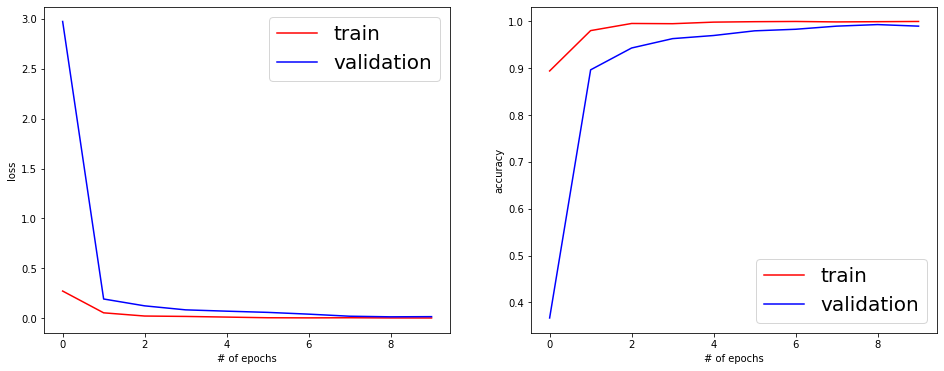

In [24]:
history = model.fit_generator(train_batches,

                              steps_per_epoch=train_steps,

                              class_weight= class_weights,

                              validation_data=valid_batches,

                              validation_steps=val_steps,

                              epochs=10,

                              verbose=1,

                              callbacks=callbacks_list)


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='validation')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['categorical_accuracy'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_categorical_accuracy'], 'b-', label='validation')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

## **Test accuracy by the Model**

In [25]:
# Evaluation of the last epoch
value_loss, value_cat_acc = model.evaluate_generator(test_batches, steps=test_steps)

print('value_loss:', value_loss)

print('value_cat_acc:', value_cat_acc)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


value_loss: 0.009277849458158016
value_cat_acc: 0.9983333349227905


In [26]:
test_labels = test_batches.classes
print(len(test_batches))

1


In [27]:
test_image_batch, test_label_batch = next(iter(test_batches))
true_label_ids = np.argmax(test_label_batch, axis=-1)

print("test batch shape:", test_image_batch.shape)
print(true_label_ids)

test batch shape: (600, 224, 224, 3)
[0 0 1 1 1 2 0 1 2 2 2 2 1 1 1 0 1 1 0 1 2 0 1 2 0 1 2 0 1 1 2 0 2 2 1 2 2
 0 1 1 1 2 0 1 1 1 2 0 0 0 0 0 0 1 0 0 1 2 0 2 1 1 2 2 0 0 0 0 0 2 2 2 2 2
 2 0 2 1 2 0 1 2 2 2 1 0 1 1 2 1 2 2 2 2 0 2 0 0 2 0 1 1 1 1 1 0 1 2 2 1 1
 2 1 1 0 2 2 1 1 2 1 1 2 1 0 1 2 1 0 2 0 2 1 0 1 0 2 2 0 2 0 2 2 1 0 1 0 2
 2 1 0 0 0 0 0 0 0 2 1 1 2 0 0 0 2 0 1 1 0 0 1 1 2 1 0 1 2 0 1 2 1 2 2 0 2
 2 1 0 2 2 1 1 1 0 0 0 1 2 2 1 0 1 0 1 0 0 1 2 2 2 0 2 1 2 2 1 1 2 2 0 0 0
 0 0 1 2 1 1 2 1 2 0 1 1 2 1 2 1 1 2 0 0 0 2 0 1 0 0 0 1 1 1 1 0 0 0 0 1 2
 0 0 1 2 0 2 2 0 1 2 2 1 2 1 0 0 0 1 1 1 1 1 0 0 2 0 1 0 0 0 0 1 1 0 0 0 1
 0 2 0 2 2 2 0 0 0 2 2 2 2 0 2 2 0 0 0 0 1 0 0 0 0 1 1 0 0 2 1 0 0 1 0 1 0
 0 2 2 2 1 0 1 0 2 1 2 2 1 1 2 1 2 2 2 2 0 1 2 1 1 2 2 2 0 1 0 2 2 0 2 0 0
 1 1 2 1 1 2 1 1 2 0 1 2 0 0 0 0 0 2 1 2 0 0 1 0 0 0 2 0 1 1 0 2 2 1 1 1 2
 0 0 2 1 1 1 2 2 2 1 1 1 1 0 0 1 2 0 0 1 2 2 2 1 1 2 1 2 1 1 1 2 2 0 2 0 2
 1 1 2 2 2 2 2 2 1 1 1 0 2 2 1 1 2 2 0 0 2 0 0 1 1 1 0 1 1 2 1 

In [28]:
# Make predictions
predictions = model.predict_generator(test_batches, steps=test_steps, verbose=1)
print(predictions.argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1/1 [==============================] - 12s 12s/step
[0 0 1 1 1 2 0 1 2 2 2 2 1 1 1 0 1 1 0 1 2 0 1 2 0 1 2 0 1 1 2 0 2 2 1 2 2
 0 1 1 1 2 0 1 1 1 2 0 0 0 0 0 0 1 0 0 1 2 0 2 1 1 2 2 0 0 0 0 0 2 2 2 2 2
 2 0 2 1 2 0 1 2 2 2 1 0 1 1 2 1 2 2 2 2 0 2 0 0 2 0 1 1 1 1 1 0 1 2 2 1 1
 2 1 1 0 2 2 1 1 2 1 1 2 1 0 1 2 1 0 2 0 2 1 0 1 0 2 2 0 2 0 2 2 1 0 1 0 2
 2 1 0 0 0 0 0 0 0 2 1 1 2 0 0 0 2 0 1 1 0 0 1 1 2 1 0 1 2 0 1 2 1 2 2 0 2
 2 1 0 2 2 1 1 1 0 0 0 1 2 2 1 0 1 0 1 0 0 1 2 2 2 0 2 1 2 2 1 1 2 2 0 0 0
 0 0 1 2 1 1 2 1 2 0 1 1 2 1 2 1 1 2 0 0 0 2 0 1 0 0 0 1 1 1 1 0 0 0 0 1 2
 0 0 1 2 0 2 2 0 1 2 2 1 2 1 0 0 0 1 1 1 1 1 0 0 2 0 1 0 0 0 0 1 1 0 0 0 1
 0 2 0 2 2 2 0 2 0 2 2 2 2 0 2 2 0 0 0 0 1 0 0 0 0 1 1 0 0 2 1 0 0 1 0 1 0
 0 2 2 2 1 0 1 0 2 1 2 2 1 1 2 1 2 2 2 2 0 1 2 1 1 2 2 2 0 1 0 2 2 0 2 0 0
 1 1 2 1 1 2 1 1 2 0 1 2 0 0 0 0 0 2 1 2 0 0 1 0 0 0 2 0 1 1 0 2 2 1 1 1 2
 0 0 2 1 1 1 2 2 2 1 1 1 1 0 0 1 2 0 0 1 2 2 2 1 1 2 1 2 1 1 1 2 2 0 2 0 2
 1 1 2 2 2 2 2 2 1 1 1 0 2 2 1 1 2 2 0 0 2 0 0 1

## **Confusion Matrix for Visual Proof of Model Success**

Confusion matrix, without normalization
[[199   0   1]
 [  0 200   0]
 [  0   0 200]]


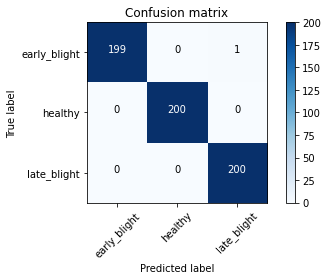

In [29]:
# Declare a function for plotting the confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')



    print(cm)



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    fmt = '.2f' if normalize else 'd'

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, format(cm[i, j], fmt),

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")



    plt.ylabel('True label')

    plt.xlabel('Predicted label')

    plt.tight_layout()


cm = confusion_matrix(true_label_ids, predictions.argmax(axis=1))



cm_plot_labels = ['early_blight', 'healthy','late_blight']



plot_confusion_matrix(cm, cm_plot_labels)

## **Manually Calculating the Test Accuracy**

In [30]:
c=0
i=0
while i < 600:
  if true_label_ids[i]== predictions.argmax(axis=1)[i]:
    c=c+1
  i=i+1
print(c/600)
  


0.9983333333333333


In [31]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(true_label_ids, predictions.argmax(axis=1))))



print('Macro Precision: {:.2f}'.format(precision_score(true_label_ids, predictions.argmax(axis=1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(true_label_ids, predictions.argmax(axis=1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(true_label_ids, predictions.argmax(axis=1), average='macro')))



from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(true_label_ids, predictions.argmax(axis=1), target_names=['early_blight', 'healthy', 'late_blight']))


Accuracy: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00


Classification Report

              precision    recall  f1-score   support

early_blight       1.00      0.99      1.00       200
     healthy       1.00      1.00      1.00       200
 late_blight       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

